In [1]:
# prompt: print version of keras,python and tensorflow

import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)
!python --version


3.5.0
2.17.1
Python 3.10.12


In [2]:
import os
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
import albumentations as A


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

def load_and_resize_data(image_folder, mask_folder, target_size=(256, 256)):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
    mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder)])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Load images in RGB mode
        img = load_img(img_file, color_mode="rgb", target_size=target_size)
        # Load masks in grayscale mode
        mask = load_img(mask_file, color_mode="grayscale", target_size=target_size)

        img = img_to_array(img)
        mask = img_to_array(mask)

        # Replicate the grayscale mask into 3 channels
        mask = np.repeat(mask, 3, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

image_folder = '/content/drive/MyDrive/splited dataset/clahe images'
mask_folder ='/content/drive/MyDrive/splited dataset/splited masks'

images, masks = load_and_resize_data(image_folder, mask_folder)

# Normalize images and masks
images = images / 255.0
masks = masks / 255.0

# Ensure the shape is (256, 256, 3)
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")


Images shape: (456, 256, 256, 3)
Masks shape: (456, 256, 256, 3)


In [4]:
def augment(image, mask):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p=0.5),
        A.ShiftScaleRotate(p=0.5)
    ])

    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Apply augmentation
augmented_images = []
augmented_masks = []

for img, msk in zip(images, masks):
    img_aug, msk_aug = augment(img, msk)
    augmented_images.append(img_aug)
    augmented_masks.append(msk_aug)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_resnet50(input_shape=(256, 256, 3), num_classes=1):

    # Load ResNet50 with ImageNet weights, excluding top layers
    inputs = Input(input_shape)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder (Feature extraction with ResNet50)
    x2 = base_model.get_layer('conv1_relu').output
    x3 = base_model.get_layer('conv2_block3_out').output
    x4 = base_model.get_layer('conv3_block4_out').output
    x5 = base_model.get_layer('conv4_block6_out').output
    x6 = base_model.get_layer('conv5_block3_out').output

    # Decoder (Up-sampling)
    d1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(x6)
    d1 = concatenate([d1, x5])
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)

    d2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(d1)
    d2 = concatenate([d2, x4])
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)

    d3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(d2)
    d3 = concatenate([d3, x3])
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)

    d4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(d3)
    d4 = concatenate([d4, x2])
    d4 = Conv2D(64, 3, activation='relu', padding='same')(d4)
    d4 = Conv2D(64, 3, activation='relu', padding='same')(d4)

    d5 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(d4)
    d5 = Conv2D(32, 3, activation='relu', padding='same')(d5)
    d5 = Conv2D(32, 3, activation='relu', padding='same')(d5)

    # Output Layer: Adjusting for 3 output channels
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(d5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create U-Net model with ResNet50 backbone
model = unet_resnet50(input_shape=(256, 256, 3), num_classes=1)
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 40,943,553 (156.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_masks, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(342, 256, 256, 3)
(114, 256, 256, 3)


In [7]:
print(y_train.shape)
print(y_test.shape)

(342, 256, 256, 3)
(114, 256, 256, 3)


In [8]:
y_train_gray = tf.reduce_mean(y_train, axis=-1, keepdims=True)
y_test_gray = tf.reduce_mean(y_test, axis=-1, keepdims=True)
print(y_train_gray.shape)
print(y_test_gray.shape)

(342, 256, 256, 1)
(114, 256, 256, 1)


In [9]:
history=model.fit(X_train,y_train_gray,validation_data=(X_test,y_test_gray),epochs=50,batch_size=16)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.7146 - loss: 0.5309 - val_accuracy: 0.5064 - val_loss: 17.4402
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - accuracy: 0.8627 - loss: 0.3144 - val_accuracy: 0.4824 - val_loss: 0.7693
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.8788 - loss: 0.2795 - val_accuracy: 0.4824 - val_loss: 8.2253
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accuracy: 0.8732 - loss: 0.2927 - val_accuracy: 0.4846 - val_loss: 26.3456
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 462ms/step - accuracy: 0.8864 - loss: 0.2616 - val_accuracy: 0.4912 - val_loss: 0.7791
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - accuracy: 0.8879 - loss: 0.2579 - val_accuracy: 0.5328 - val_loss: 0.6840
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8900 - loss: 0.2529 - val_accuracy: 0.4824 - val_loss: 1.1912
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8903 - loss: 0.2518 - val_accu

In [10]:
model.save('/content/drive/MyDrive/splited dataset/new_unet_model2.h5')

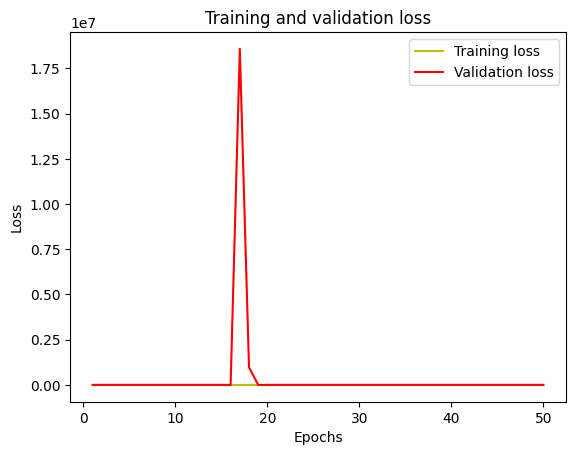

In [11]:
import matplotlib.pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

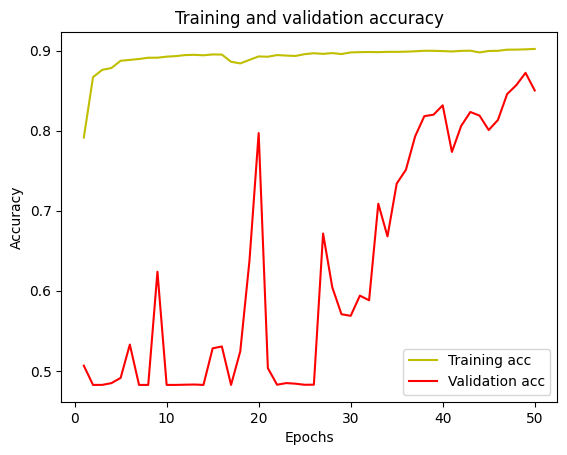

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_gray, y_pred_thresholded)
union = np.logical_or(y_test_gray, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step
IoU socre is:  0.7681970332775274


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


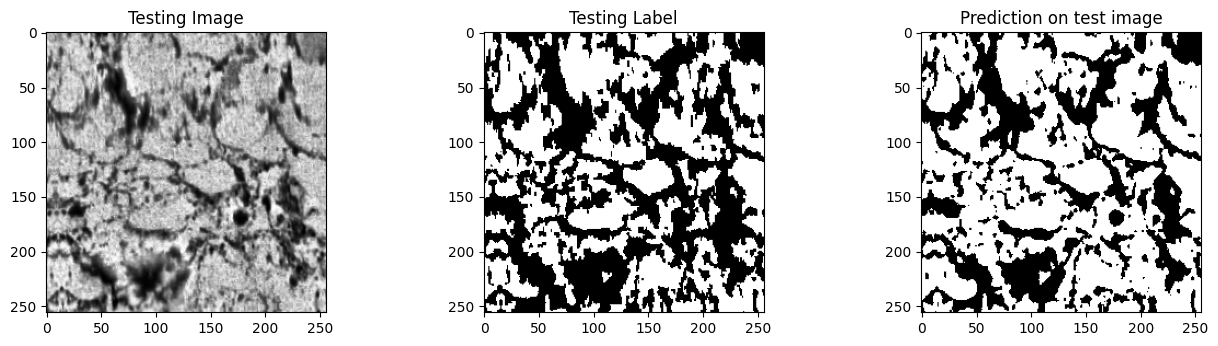

In [19]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
test_img_input = np.repeat(test_img_input, 3, axis=-1)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.3).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


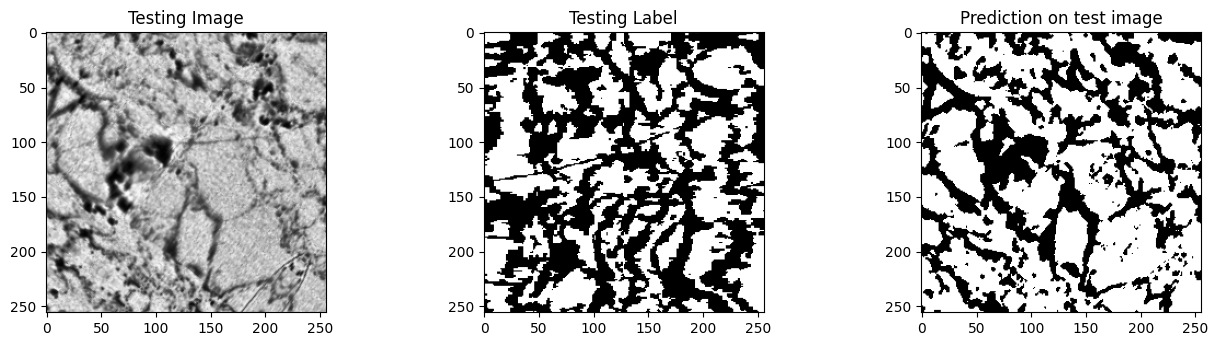

In [22]:
test_img = X_train[10]
ground_truth=y_test_gray[10]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
test_img_input = np.repeat(test_img_input, 3, axis=-1)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


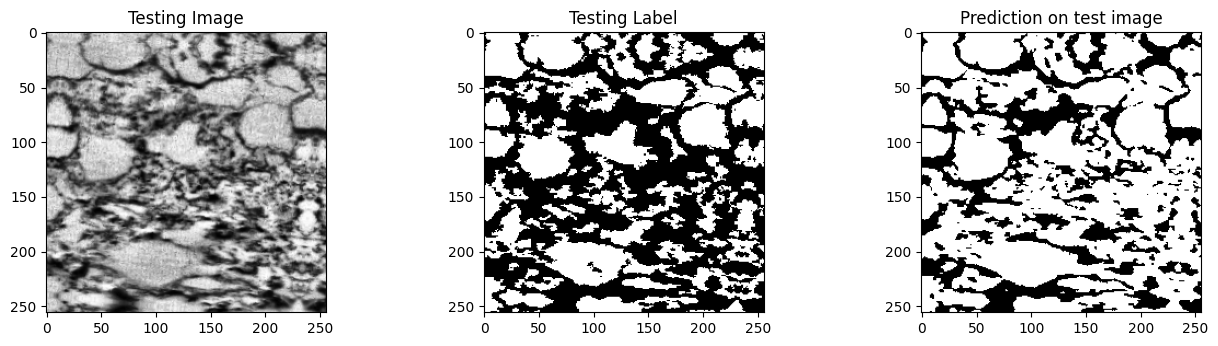

In [46]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
test_img_input = np.repeat(test_img_input, 3, axis=-1)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()